In [ ]:
import mpmath as mp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



def set_precision(dps=50):
    mp.mp.dps = dps



# Fase de Riemann–Siegel


def theta_rs(t, dps=None):
    if dps is None:
        t_mp = mp.mpf(t)
        s = mp.mpf('0.5') + 1j * t_mp
        z = s / 2
        theta = mp.im(mp.log(mp.gamma(z)) - z * mp.log(mp.pi))
        return theta
    else:
        with mp.workdps(dps):
            t_mp = mp.mpf(t)
            s = mp.mpf('0.5') + 1j * t_mp
            z = s / 2
            theta = mp.im(mp.log(mp.gamma(z)) - z * mp.log(mp.pi))
            return +theta  # copia en precisión local


# Suma principal de Riemann–Siegel


def rs_truncation_N(t):
    t_mp = mp.mpf(t)
    if t_mp <= 0:
        raise ValueError("La fórmula de Riemann–Siegel se usa para t > 0.")
    N = int(mp.floor(mp.sqrt(t_mp / (2 * mp.pi))))
    if N < 1:
        N = 1
    return N


def rs_main_sum(t, N=None, dps=50):
    set_precision(dps)
    t_mp = mp.mpf(t)

    if N is None:
        N = rs_truncation_N(t_mp)

    theta = theta_rs(t_mp)  # usa la precisión global actual

    s = mp.mpf('0')
    for n in range(1, N + 1):
        n_mp = mp.mpf(n)
        s += n_mp**(-mp.mpf('0.5')) * mp.cos(theta - t_mp * mp.log(n_mp))

    Z_main = 2 * s
    return Z_main, theta, N


# Cola de Riemann–Siegel


def psi_rs(p):

    p_mp = mp.mpf(p)
    return mp.cos(2 * mp.pi * (p_mp**2 - p_mp - mp.mpf('1')/16)) / mp.cos(2 * mp.pi * p_mp)


def rs_numeric_correction(t, Z_main, dps_main=50, dps_corr=None, N_used=None):

    if dps_corr is None:
        dps_corr = dps_main
    set_precision(dps_corr)

    t_mp = mp.mpf(t)
    if t_mp <= 0:
        raise ValueError("t debe ser positivo en la cola RS.")

    if N_used is None:
        N_used = rs_truncation_N(t_mp)

    X = t_mp / (2 * mp.pi)
    a = mp.sqrt(X)
    p = a - N_used
    p = p - mp.floor(p)             # forzamos 0 <= p < 1 por si acaso

    psi_val = psi_rs(p)
    pref = (-1)**(N_used - 1) * X**(-mp.mpf('0.25'))
    R = pref * psi_val

    return +R, None



# Implementación completa de Z(t) por Riemann–Siegel

def Z_rs(t, N=None, dps=50,
         use_numeric_correction=False,
         dps_correction=None,
         return_components=False):

    # Suma principal
    Z_main, theta, N_used = rs_main_sum(t, N=N, dps=dps)

    # Cola / corrección (ahora asintótica RS real)
    if use_numeric_correction:
        R, Z_true = rs_numeric_correction(
            t, Z_main, dps_main=dps, dps_corr=dps_correction, N_used=N_used
        )
    else:
        R = mp.mpf('0')
        Z_true = None

    Z_approx = Z_main + R

    if return_components:
        components = {
            'theta': theta,
            'N': N_used,
            'Z_main': Z_main,
            'R': R,
            'Z_true': Z_true
        }
        return Z_approx, components
    else:
        return Z_approx



# Reconstrucción a partir de Z(t)


def zeta_rs(t, **Z_kwargs):
    dps = Z_kwargs.get('dps', mp.mp.dps)
    set_precision(dps)

    Z_val = Z_rs(t, **Z_kwargs) if not Z_kwargs.get('return_components', False) else Z_rs(t, **Z_kwargs)[0]
    theta = theta_rs(t)

    zeta_val = mp.e**(-1j * theta) * Z_val

    extra = {
        'Z': Z_val,
        'theta': theta
    }
    return zeta_val, extra



# Referencia de alta precisión para Z(t)


def Z_reference(t, dps_ref=80):
    with mp.workdps(dps_ref):
        t_mp = mp.mpf(t)
        s = mp.mpf('0.5') + 1j * t_mp

        zeta_val = mp.zeta(s)
        theta = theta_rs(t_mp)

        Z_complex = mp.e**(1j * theta) * zeta_val
        Z_ref = mp.re(Z_complex)

        return +Z_ref, +Z_complex, +theta



# Referencia de alta precisión para ζ


def zeta_reference(t, dps_ref=80):
    with mp.workdps(dps_ref):
        t_mp = mp.mpf(t)
        s = mp.mpf('0.5') + 1j * t_mp
        return mp.zeta(s)




# Test de Z_rs contra referencia


def test_Z_rs_on_values(t_values,
                        dps_rs=50,
                        dps_ref=80,
                        N=None,
                        use_numeric_correction=False,
                        show_table=True):

    rows = []

    for t in t_values:

        Z_ref, Z_ref_complex, theta_ref = Z_reference(t, dps_ref=dps_ref)


        Z_rs_val, comps = Z_rs(
            t,
            N=N,
            dps=dps_rs,
            use_numeric_correction=use_numeric_correction,
            return_components=True
        )


        abs_error = mp.fabs(Z_rs_val - Z_ref)
        if Z_ref != 0:
            rel_error = abs_error / mp.fabs(Z_ref)
        else:
            rel_error = mp.nan  # caso raro: Z_ref = 0

        row = {
            't': float(t),
            'Z_ref': float(Z_ref),
            'Z_RS': float(Z_rs_val),
            'abs_error': float(abs_error),
            'rel_error': float(rel_error),
            'Im(Z_ref_complex)': float(mp.im(Z_ref_complex)),
            'N_used': int(comps['N']),
        }
        rows.append(row)

    df = pd.DataFrame(rows)

    if show_table:
        header = (
            f"{'t':>12} | {'Z_ref':>30} | {'Z_RS':>30} | "
            f"{'abs_error':>12} | {'rel_error':>12} | {'Im(Z_ref)':>12} | {'N_used':>7}"
        )
        print(header)
        print("-" * len(header))
        for row in rows:
            t_print = row['t']
            z_ref = row['Z_ref']
            z_rs = row['Z_RS']
            err_abs = row['abs_error']
            err_rel = row['rel_error']
            im_zref = row['Im(Z_ref_complex)']
            N_used = row['N_used']

            print(
                f"{t_print:12.8f} | "
                f"{z_ref:30.12f} | "
                f"{z_rs:30.12f} | "
                f"{err_abs:12.2e} | "
                f"{err_rel:12.2e} | "
                f"{im_zref:12.2e} | "
                f"{N_used:7d}"
            )

    return df




t_test_values = [
    1.0,
    5.0,
    10.0,
    14.13472514,  # primer cero (aprox)
    21.02203964,  # segundo cero (aprox)
    25.01085758,  # tercer cero (aprox)
    30.0,
    50.0,
    100.0,
    200.0
]

# Ejemplo 1: solo suma principal, sin corrección
df_main = test_Z_rs_on_values(
    t_values=t_test_values,
    dps_rs=50,
    dps_ref=80,
    N=None,
    use_numeric_correction=False,
    show_table=True
)

# Ejemplo 2: suma principal + cola asintótica de Riemann–Siegel
df_with_corr = test_Z_rs_on_values(
    t_values=t_test_values,
    dps_rs=50,
    dps_ref=90,
    N=None,
    use_numeric_correction=True,
    show_table=True
)


           t |                          Z_ref |                           Z_RS |    abs_error |    rel_error |    Im(Z_ref) |  N_used
-------------------------------------------------------------------------------------------------------------------------------------
  1.00000000 |                -0.736305462867 |                -0.390969330899 |     3.45e-01 |     4.69e-01 |    -1.26e-81 |       1
  5.00000000 |                -0.738863428275 |                -1.899707968505 |     1.16e+00 |     1.57e+00 |    -5.63e-81 |       1
 10.00000000 |                -1.549194546181 |                -1.994449598477 |     4.45e-01 |     2.87e-01 |    -1.56e-80 |       1
 14.13472514 |                -0.000000001376 |                -0.314437849027 |     3.14e-01 |     2.29e+08 |    -1.12e-87 |       1
 21.02203964 |                -0.000000001397 |                -0.437581339075 |     4.38e-01 |     3.13e+08 |    -9.02e-88 |       1
 25.01085758 |                -0.000000000200 |               

In [ ]:


def zeta_reference(t, dps_ref=80):
    with mp.workdps(dps_ref):
        t_mp = mp.mpf(t)
        s = mp.mpf('0.5') + 1j * t_mp
        return mp.zeta(s)




import time

def test_zeta_rs_on_values(t_values,
                           dps_rs=50,
                           dps_ref=80,
                           N=None,
                           use_numeric_correction=False,
                           show_table=True):

    rows = []

    for t in t_values:

        z_ref = zeta_reference(t, dps_ref=dps_ref)


        t0 = time.perf_counter()
        z_rs, extra = zeta_rs(
            t,
            N=N,
            dps=dps_rs,
            use_numeric_correction=use_numeric_correction
        )
        t1 = time.perf_counter()
        elapsed = t1 - t0   # tiempo en segundos


        abs_error = mp.fabs(z_rs - z_ref)
        rel_error = abs_error / mp.fabs(z_ref) if z_ref != 0 else mp.nan


        rows.append({
            't': float(t),
            'zeta_mpmath': float(mp.re(z_ref)),
            'zeta_RS': float(mp.re(z_rs)),
            'err_abs': float(abs_error),
            'err_rel': float(rel_error),
            'time_s': elapsed,
        })


    if show_table:
        header = (
            f"{'t':>12} | {'zeta_mpmath':>30} | {'zeta_RS':>30} | "
            f"{'err_abs':>12} | {'err_rel':>12} | {'time_s':>10}"
        )
        print(header)
        print("-" * len(header))

        for row in rows:
            print(
                f"{row['t']:12.8f} | "
                f"{row['zeta_mpmath']:30.12f} | "
                f"{row['zeta_RS']:30.12f} | "
                f"{row['err_abs']:12.2e} | "
                f"{row['err_rel']:12.2e} | "
                f"{row['time_s']:10.4f}"
            )

    return pd.DataFrame(rows)




t_test_values = [10, 20, 30, 14.13472514, 21.02203964, 25.01085758, 100, 200, 500]

df_zeta_rs = test_zeta_rs_on_values(
    t_values=t_test_values,
    dps_rs=50,
    dps_ref=90,
    N=None,
    use_numeric_correction=True,
    show_table=True
)


           t |                    zeta_mpmath |                        zeta_RS |      err_abs |      err_rel |     time_s
-------------------------------------------------------------------------------------------------------------------------
 10.00000000 |                 1.544895220297 |                 1.554969454452 |     1.01e-02 |     6.52e-03 |     0.0012
 20.00000000 |                 0.429913860438 |                 0.431157086053 |     3.32e-03 |     2.89e-03 |     0.0013
 30.00000000 |                -0.120642287590 |                -0.121336704330 |     3.43e-03 |     5.76e-03 |     0.0013
 14.13472514 |                 0.000000000216 |                 0.000308875023 |     1.96e-03 |     1.43e+06 |     0.0012
 21.02203964 |                 0.000000000306 |                -0.000581755507 |     2.66e-03 |     1.90e+06 |     0.0012
 25.01085758 |                 0.000000000066 |                 0.003383332127 |     1.03e-02 |     5.16e+07 |     0.0014
100.00000000 |          

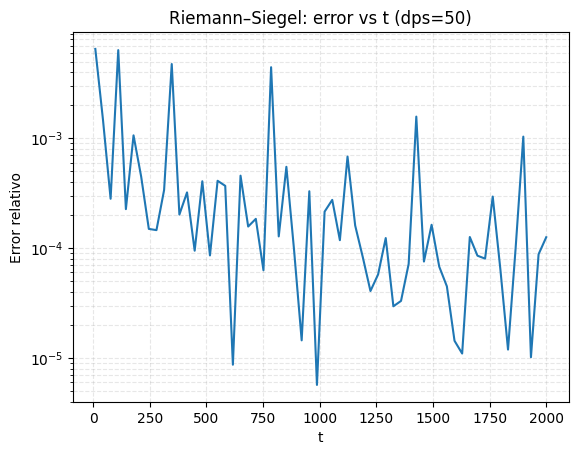

In [ ]:


def plot_error_vs_t_rs(
    t_min=10.0,
    t_max=2000.0,
    num_points=60,
    dps_rs=50,
    dps_ref=90,
    use_relative=True,
    use_numeric_correction=True,
    N=None
):

    set_precision(dps_rs)
    t_values = np.linspace(t_min, t_max, num_points)

    errors = []
    for t in t_values:
        z_ref = zeta_reference(t, dps_ref=dps_ref)
        z_rs, extra = zeta_rs(
            t,
            N=N,
            dps=dps_rs,
            use_numeric_correction=use_numeric_correction
        )

        abs_err = mp.fabs(z_rs - z_ref)
        if use_relative and z_ref != 0:
            err = abs_err / mp.fabs(z_ref)
        else:
            err = abs_err
        errors.append(float(err))

    t_plot = [float(t) for t in t_values]

    plt.figure()
    plt.semilogy(t_plot, errors)
    plt.xlabel("t")
    plt.ylabel("Error relativo" if use_relative else "Error absoluto")
    plt.title(f"Riemann–Siegel: error vs t (dps={dps_rs})")
    plt.grid(True, which="both", linestyle="--", alpha=0.3)
    plt.show()

plot_error_vs_t_rs()
